In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.tree            import DecisionTreeRegressor
from sklearn.neural_network  import MLPRegressor
from sklearn.linear_model    import LinearRegression
from sklearn.ensemble        import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics         import mean_squared_error
from sklearn.metrics         import r2_score

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [78]:
train_df = pd.read_csv("C:\\Users\\Dashang\\Downloads\\Github\\Stayze_Rent_Predicition\\Stayze_Rent_Predicition_Hackathon\\Dashang\\data\\Train.csv")

In [79]:
test_df = pd.read_csv("C:\\Users\\Dashang\\Downloads\\Github\\Stayze_Rent_Predicition\\Stayze_Rent_Predicition_Hackathon\\Dashang\\data\\Test.csv")

In [80]:
train_df.isnull().sum()

id                                   0
name                                12
host_id                              0
host_name                           13
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       6982
reviews_per_month                 6982
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [81]:
train_df = train_df.select_dtypes(exclude=['object'])

In [82]:
train_df.isnull().sum()

id                                   0
host_id                              0
latitude                             0
longitude                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
reviews_per_month                 6982
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [83]:
train_df['reviews_per_month']=train_df['reviews_per_month'].fillna(0)

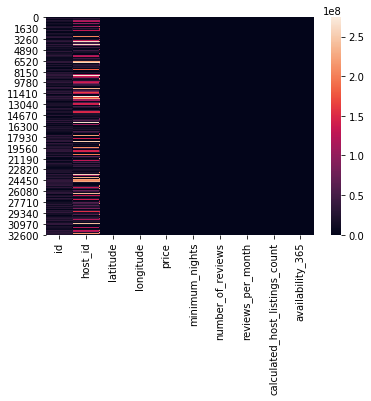

In [84]:
sns.heatmap(train_df)

In [85]:
test_df = test_df.select_dtypes(exclude=['object'])

In [86]:
train_df.columns 

Index(['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [87]:
test_df.columns

Index(['id', 'host_id', 'latitude', 'longitude', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [15]:
len(train_df.neighbourhood.unique()) , len(train_df.neighbourhood_group.unique()), len(test_df.neighbourhood.unique()) , len(test_df.neighbourhood_group.unique())

(217, 5, 207, 5)

In [37]:
from scipy.stats.mstats import winsorize 
# Function to treat outliers 
def treat_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.1, 0.1],inclusive=(True, True))
    
    return dataframe    


In [88]:
train_df['log_(price+1)'] = np.log1p(train_df['price'])

In [34]:
def removal_of_outliers(df,room_t, nhood, distance):
    '''Function removes outliers that are above 3rd quartile and below 1st quartile'''
    '''The exact cutoff distance above and below can be adjusted'''

    new_piece = df[(df["room_type"]==room_t)&(df["neighbourhood_group"]==nhood)]["log_price"]
    #defining quartiles and interquartile range
    q1 = new_piece.quantile(0.25)
    q3 = new_piece.quantile(0.75)
    IQR=q3-q1

    trimmed = df[(df.room_type==room_t)&(df["neighbourhood_group"]==nhood) &(df.log_price>(q1-distance*IQR))&(df.log_price<(q3+distance*IQR))]
    return trimmed

In [17]:
def date_replacement(date):
    if date <=3:
        return "Last_review_last_three_day"
    elif date <= 7:
        return "Last_review_last_week"
    elif date <= 30:
        return "Last_review_last_month"
    elif date <= 183:
        return "Last_review_last_half_year"
    elif date <= 365:
        return "Last_review_last year"
    elif date <= 1825:
        return "Last_review_last_5_years"
    else:
        return "Last_review_never"

In [29]:
def PreProcessing(df):
    #fill missing values for last review and reviews per month with 0
    df[["last_review", "reviews_per_month"]] = df[["last_review", "reviews_per_month"]].fillna(0)
    
    #if there is no host name or listing name fill in None
    df[["name", "host_name"]] = df[["name", "host_name"]].fillna("None")
    df = df.drop(['latitude','longitude'],axis=1)
    
    #Drop rows were price of the listing is 0. We are not intersted in "free" 
    #listings as they are most likely an error.
    if 'price' in df.columns:
        free = len(df[df.price == 0])
        df = df[df.price != 0].copy()
    
    df = df[df["minimum_nights"] <=31].copy()
    #df = df.drop(['id','host_id'],axis=1)
    
    #separate out numerical variables
    a=pd.DataFrame(df.dtypes.copy())
    b= a[a[0] != 'object'].reset_index()
    #drop id and host id:
    numeric_vars= df.select_dtypes(exclude=['object'])
    
    #for num in numeric_vars:
    #    df["log_("+num+" +1)"] = np.log(df[num]+1)
        
    if 'price' in df.columns:
        df["log_price"] = np.log1p(df.price)
    df=df.drop(columns = numeric_vars[2:]).copy()
    
    #numeric_vars = df.columns.tolist()[6:8]+df.columns.tolist()[10:]
    #x=df[numeric_vars].apply(lambda x: np.log(np.abs(x+1))).corr(method='pearson')
    
    #separate out numerical variables
    #a=pd.DataFrame(df.dtypes.copy())
    #b= a[a[0] == 'object'].reset_index()
    #drop id and host id:
    #non_num=b["index"].tolist()
    
    grouped = df.groupby("neighbourhood")
    
    if 'price' in df.columns:
        price_grouped = grouped["log_price"]
        price = price_grouped.agg([np.mean,np.median,np.max, np.std]).sort_values("mean")
    
    #One hot encoding
    #df = pd.concat([df, pd.get_dummies(df["neighbourhood"], drop_first=False)], axis=1)
    #save neighborhoods into a list for further analysis:
    #neighborhoods = df.neighbourhood.values.tolist()
    boroughs = df.neighbourhood_group.unique().tolist()
    #drop the neighbourhood column from the database
    df.drop(['neighbourhood'],axis=1, inplace=True)
    
    grouped = df.groupby("room_type")
    if 'price' in df.columns:
        room_type_price_grouped = grouped["log_price"]
        room_type_price = room_type_price_grouped.agg([np.mean,np.median,np.max, np.std]).sort_values("mean")
        room_type_price
    
    if 'price' in df.columns:
        #apply the function
        df_private = pd.DataFrame()
        for neighborhood in boroughs:
            a = removal_of_outliers(df, "Private room",neighborhood,3)
            df_private = df_private.append(a)

        df_shared = pd.DataFrame()
        for neighborhood in boroughs:
            a = removal_of_outliers(df, "Shared room",neighborhood,3)
            df_shared = df_shared.append(a)
    
        df_apt = pd.DataFrame()
        for neighborhood in boroughs:
            a = removal_of_outliers(df, "Entire home/apt",neighborhood,3)
            df_apt = df_apt.append(a)
    
        # Create new dataframe to absorb newly produced data    
        df_old=df.copy()    
        df = pd.DataFrame()
        df = df.append([df_private,df_shared,df_apt])

    grouped = df.groupby("room_type")
    if 'price' in df.columns:
        room_type_price_grouped = grouped["log_price"]
        room_type_price = room_type_price_grouped.agg([np.mean,np.median,np.max, np.std]).sort_values("mean")
    
    #convert room types to dummies
    df = pd.concat([df, pd.get_dummies(df["room_type"], drop_first=False)], axis=1)
    df.drop(['room_type'],axis=1, inplace=True)
    
    #convert object to datetime:
    df["last_review"] = pd.to_datetime(df["last_review"])
    
    df["last_review"]=df["last_review"].apply(lambda x: dt.datetime(2019,7,8)-x)
    df["last_review"]=df["last_review"].dt.days.astype("int").replace(18085, 1900)
    
    df["last_review"]=df["last_review"].apply(lambda x: date_replacement(x))
    grouped = df.groupby("last_review")
    if 'price' in df.columns:
        last_review_price_grouped = grouped["log_price"]
        last_review_price = last_review_price_grouped.agg([np.mean,np.median,np.max, np.std]).sort_values("mean")
    
    #convert last review to dummies
    df = pd.concat([df, pd.get_dummies(df["last_review"], drop_first=False)], axis=1)
    df.drop(["last_review"],axis=1, inplace=True)

     #convert last review to dummies
    df = pd.concat([df, pd.get_dummies(df['neighbourhood_group'], drop_first=False)], axis=1)
    df.drop(['neighbourhood_group'],axis=1, inplace=True)
    
    #drop unnecessary columns
    df = df.drop(['name','host_name'], axis=1).copy()
    #copy for later
    #df2 = df.copy()
    return df
    

In [30]:
train_df = PreProcessing(train_df)

KeyError: "['last_review'] not in index"

In [60]:
train_df.isna().sum()

id                                0
host_id                           0
latitude                          0
longitude                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [61]:
train_df.columns

Index(['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [155]:
train_df = train_df.drop(['log_(id +1)','log_(host_id +1)'],axis=1)

KeyError: "['log_(id +1)' 'log_(host_id +1)'] not found in axis"

In [157]:
train_df.columns

Index(['log_price', 'Entire home/apt', 'Private room', 'Shared room',
       'Last_review_last year', 'Last_review_last_5_years',
       'Last_review_last_half_year', 'Last_review_last_month',
       'Last_review_last_three_day', 'Last_review_last_week',
       'Last_review_never', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens',
       'Staten Island'],
      dtype='object')

target = train_df['log_price'].copy()
#drop unnecessary columns
train_df = train_df.drop(['log_price'], axis=1).copy()
#strip the target column from input columns and put it in front
train_df = pd.concat([target, train_df], axis=1).copy()
#select input variable columns
nums = train_df.iloc[:,1:]

In [40]:
train_df

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,5728806,4271676,40.72217,-73.99481,4.795791,7,3,0.06,3,0
1,2243769,11460768,40.80020,-73.96045,7.313887,1,0,0.00,1,0
2,35515415,267193767,40.75558,-73.89316,5.303305,2,4,4.00,1,365
3,36202006,43392243,40.60110,-74.07830,3.433987,2,0,0.00,4,82
4,3780951,16065171,40.81022,-73.94266,4.753590,1,16,0.27,1,365
...,...,...,...,...,...,...,...,...,...,...
34221,28342248,120730056,40.70602,-73.90485,4.394449,5,2,0.21,1,0
34222,8438775,41042927,40.77697,-73.97698,4.927254,1,163,3.55,1,32
34223,27332770,80381355,40.86912,-73.92183,5.278115,2,6,0.53,1,0
34224,9063972,3040551,40.69709,-73.91435,4.394449,3,0,0.00,1,0


In [ ]:
vif_df = train_df._get_numeric_data() #This line will drop non-numeric cols

vif_df.head()

# For each X, calculate VIF and save in dataframe

vif = pd.DataFrame()

vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif["features"] = X.columns



In [62]:
train_df = train_df.drop(['id','host_id'],axis=1)

In [67]:
features = train_df.drop(['price'],axis=1).columns

In [65]:
train_df = train_df.drop(['latitude','longitude'],axis=1)

In [68]:
'price'+ '+'.join(features)

'priceminimum_nights+number_of_reviews+reviews_per_month+calculated_host_listings_count+availability_365'

In [93]:
train_df.columns

Index(['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'log_(price+1)'],
      dtype='object')

In [69]:

from patsy import dmatrices


In [195]:

# get y and X dataframes based on this regression:
u, C = dmatrices('price ~ Last_review_last_5_years+Last_review_last_half_year+Last_review_last_month+Last_review_last_three_day+Last_review_last_week+Last_review_never+Bronx+Brooklyn+Manhattan+Queens', train_df, return_type='dataframe')

In [196]:
VIF = pd.DataFrame()

In [197]:
VIF['Features']  = C.columns

In [198]:
VIF['VIF'] = [variance_inflation_factor(C.values , i) for i in range(C.shape[1])]

In [199]:
VIF

,Features,VIF
0,Intercept,145.978251
1,Last_review_last_5_years,2.379324
2,Last_review_last_half_year,2.230295
3,Last_review_last_month,2.555164
4,Last_review_last_three_day,1.361222
5,Last_review_last_week,1.476727
6,Last_review_never,2.420776
7,Bronx,3.979501
8,Brooklyn,33.807786
9,Manhattan,34.451965


In [200]:
X=train_df.drop(['log_price','Bronx','Brooklyn','Manhattan','Queens'],axis=1)
y=train_df['log_price']

In [94]:
train_df = train_df.drop(['id', 'host_id', 'latitude', 'longitude'],axis=1)

In [111]:
X=train_df.drop(['log_(price+1)' , 'price'],axis=1)
y=train_df['log_(price+1)']

In [112]:
train_df.isnull().sum()


price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
log_(price+1)                     0
dtype: int64

In [113]:
#y= target
#x = nums
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=24)

In [114]:
X.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,7,3,0.06,3,0
1,1,0,0.00,1,0
2,2,4,4.00,1,365
3,2,0,0.00,4,82
4,1,16,0.27,1,365


In [115]:
from sklearn.linear_model import LinearRegression

In [116]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)
print('Train RMSE:',np.sqrt(mean_squared_error(y_train, lr.predict(X_train))))
print('Test RMSE:',np.sqrt(mean_squared_error(y_test, lr.predict(X_test))))


Train RMSE: 0.6870198864527166
Test RMSE: 0.6928398524214003


## LinearReg TEST PREDICTION

In [117]:
test_df.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2,121,1.70,1,39
1,1,18,2.49,30,364
2,1,87,4.29,1,108
3,9,0,0.00,2,365
4,1,28,14.00,2,20


In [101]:
test_id_col = test_df['id']

In [102]:
test_df.columns

Index(['id', 'host_id', 'latitude', 'longitude', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [103]:
test_df = test_df.drop(['id', 'host_id', 'latitude', 'longitude'],axis=1)

In [104]:
test_df.isnull().sum()

minimum_nights                       0
number_of_reviews                    0
reviews_per_month                 3070
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [105]:
test_df['reviews_per_month']=test_df['reviews_per_month'].fillna(0)

In [118]:
test_df.isnull().sum()

minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [212]:
test_df = PreProcessing(test_df)

In [107]:
test_df.columns

Index(['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [138]:
test_df = test_df.drop(['log_(id +1)','log_(host_id +1)'],axis=1)

In [119]:
X.columns


Index(['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [120]:
test_df.columns

Index(['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [218]:
test_df = test_df.drop(['Bronx','Brooklyn','Manhattan','Queens'],axis=1)

In [121]:
X.shape ,test_df.shape

((34226, 5), (14669, 5))

In [122]:
test_df['price'] = lr.predict(test_df)

In [123]:
test_df['price'] = np.exp(test_df['price'])-1

In [124]:
submissions_lr = pd.concat([test_id_col, test_df['price']], axis=1) 


In [125]:
submissions_lr.to_csv('submission_LinearReg1.csv', index=False) 

In [126]:
submissions_lr

,id,price
0,1525602,103.351570
1,30430185,129.817771
2,21354525,101.497381
3,35995074,130.023164
4,34392081,79.208533
...,...,...
14664,27730191,110.048546
14665,29676417,129.328311
14666,1813829,122.345815
14667,25017403,109.809095


In [127]:
submissions_lr.isnull().sum()

id       0
price    0
dtype: int64